## Ideas

*2-step approach*
- Classify attack vs. benign (then evaluate)
- Classify attack type among attack packets (then evaluate)

*1-step*
- Classify attack types immediately (then evaluate)

*Per-attack-type*
- Do classification for one attack type at a time (then evaluate)

Do naive Bayes as baseline

---

*Research Questions*

---

Does 2 step do better than 1 step?

Which attacks are hardest to predict?

Which attacks are most dangerous relative to prediction difficulty?

Does feature selection / dimensionality reduction help?

In [1]:
import numpy as np
import pandas as pd
import os.path as path

#Plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import figure

# Sklearn imports
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, fbeta_score, roc_auc_score


#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In /home/victwj/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/victwj/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/victwj/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/victwj/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/victwj/.local/lib/python3.6/site-packages/matplotlib/mpl-data/s

In [2]:
data = "./cicids"
cols = [' Bwd Packet Length Std',' PSH Flag Count',' min_seg_size_forward',' Min Packet Length',
        ' ACK Flag Count',' Bwd Packet Length Min',' Fwd IAT Std','Init_Win_bytes_forward',
        ' Flow IAT Max',' Bwd Packets/s',' URG Flag Count','Bwd IAT Total',' Label']

df1 = pd.read_csv(path.join(data, "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"), usecols = cols)
df2 = pd.read_csv(path.join(data, "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"), usecols = cols)
df3 = pd.read_csv(path.join(data, "Friday-WorkingHours-Morning.pcap_ISCX.csv"), usecols = cols)
df4 = pd.read_csv(path.join(data, "Monday-WorkingHours.pcap_ISCX.csv"), usecols = cols)
df5 = pd.read_csv(path.join(data, "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"), usecols = cols)
df6 = pd.read_csv(path.join(data, "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"), usecols = cols)
df7 = pd.read_csv(path.join(data, "Tuesday-WorkingHours.pcap_ISCX.csv"), usecols = cols)
df8 = pd.read_csv(path.join(data, "Wednesday-WorkingHours.pcap_ISCX.csv"), usecols = cols)

In [41]:
df_all = [df1, df2, df3, df4, df5, df6, df7, df8]

In [4]:
df1.sample(10)

,Bwd Packet Length Min,Bwd Packet Length Std,Flow IAT Max,Fwd IAT Std,Bwd IAT Total,Bwd Packets/s,Min Packet Length,PSH Flag Count,ACK Flag Count,URG Flag Count,Init_Win_bytes_forward,min_seg_size_forward,Label
96385,0,4128.319301,128002,1.129179e+04,145131,27.548968,0,1,0,0,8192,20,DDoS
146898,6,0.000000,7734122,0.000000e+00,7755930,0.773392,6,0,1,1,229,20,BENIGN
198496,48,0.000000,100,0.000000e+00,50,10101.010100,32,0,0,0,-1,32,BENIGN
118099,0,0.000000,6961743,3.480518e+06,0,0.000000,6,0,1,0,256,20,DDoS
172260,0,3327.769794,622604,3.691097e+02,623722,8.015711,0,1,0,0,8192,20,DDoS
108998,0,3022.508098,1701559,1.290470e+04,1720944,2.905171,0,1,0,0,8192,20,DDoS
153878,0,0.000000,6046835,3.023097e+06,0,0.000000,6,0,1,0,256,20,DDoS
175278,0,0.000000,215,4.101219e+01,0,0.000000,0,0,1,0,40544,32,BENIGN
204303,94,0.000000,160,0.000000e+00,3,12048.192770,44,0,0,0,-1,32,BENIGN
162026,0,0.000000,110985,6.322814e+04,0,0.000000,6,0,1,0,256,20,DDoS


In [5]:
for i, df in enumerate(df_all):
    print("DF" + str(i + 1)) 
    print(df[' Label'].value_counts(), "\n")

DF1
DDoS      128027
BENIGN     97718
Name:  Label, dtype: int64 

DF2
PortScan    158930
BENIGN      127537
Name:  Label, dtype: int64 

DF3
BENIGN    189067
Bot         1966
Name:  Label, dtype: int64 

DF4
BENIGN    529918
Name:  Label, dtype: int64 

DF5
BENIGN          288566
Infiltration        36
Name:  Label, dtype: int64 

DF6
BENIGN                        168186
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Name:  Label, dtype: int64 

DF7
BENIGN         432074
FTP-Patator      7938
SSH-Patator      5897
Name:  Label, dtype: int64 

DF8
BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name:  Label, dtype: int64 



DF4 (Monday) is all benign.

In [6]:
len_total = 0
for i, df in enumerate(df_all):
    print("DF" + str(i + 1), len(df.index))
    len_total += len(df.index)
print("Total length:", len_total)

DF1 225745
DF2 286467
DF3 191033
DF4 529918
DF5 288602
DF6 170366
DF7 445909
DF8 692703
Total length: 2830743


## Random Forest on DF1

In [7]:
df1_labels = df1[" Label"]
df1_train = df1.drop(columns = [" Label"])

# Convert labels to binary
replace = {
    "DDoS": 1,
    "BENIGN": 0,
}
df1_labels = df1_labels.replace(replace)

In [8]:
# Cross validation
rf = RandomForestClassifier()
scores = cross_val_score(rf, df1_train, df1_labels, cv=5)

In [9]:
scores

array([0.99962347, 0.99980066, 0.99966777, 0.99971206, 0.99842743])

In [10]:
print("%0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

0.999 accuracy with a standard deviation of 0.001


In [11]:
rf = RandomForestClassifier()
xtrain, xtest, ytrain, ytest = train_test_split(df1_train, df1_labels, test_size=0.3, random_state=0)

In [12]:
rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
predictions = rf.predict(xtest)

In [14]:
print("Accuracy score: ", accuracy_score(ytest, predictions))
print("Precision score: ", precision_score(ytest, predictions))
print("Recall score: ", recall_score(ytest, predictions))

Accuracy score:  0.9996160888311382
Precision score:  0.9997389783613062
Recall score:  0.9995824307748519


## Random Forest Generic

In [27]:
rf, predictions = randomForest(df1)

Accuracy score:  0.9996013230169511
Precision score:  0.9997128836917937
Recall score:  0.9995824307748519
F1 score:  0.9996476529773322
F2 score:  0.9996085186345132
Confusion Matrix:  [[29396    11]
 [   16 38301]]
TN  29396
FN  11
FP  16
TP  38301


In [29]:
def randomForest(df):
    labels = df[" Label"]
    train = df.drop(columns = [" Label"])

    # Convert labels to binary
    replace = {}
    for label in df[" Label"].unique():
        replace[label] = 0 if label == "BENIGN" else 1
        
    labels = labels.replace(replace)
    
    rf = RandomForestClassifier()

    xtrain, xtest, ytrain, ytest = train_test_split(train, labels, test_size=0.3, random_state=0) #stratify=labels)
    rf.fit(xtrain, ytrain)
    predictions = rf.predict(xtest)
    cm = confusion_matrix(ytest, predictions)
    print(ytest.value_counts()[1])
    
    print("Accuracy score: ", accuracy_score(ytest, predictions))
    print("Precision score: ", precision_score(ytest, predictions))
    print("Recall score: ", recall_score(ytest, predictions))
    print("F1 score: ", f1_score(ytest, predictions))
    print("F2 score: ", fbeta_score(ytest, predictions, 2))
    print("FP/A: ", 1-(cm[1][0] / ytest.value_counts()[1]))
    try:
        print("TN ", cm[0][0])
        print("FN ", cm[0][1])
        print("FP ", cm[1][0])
        print("TP ", cm[1][1])
    except IndexError:
        pass
    try:
        print("AUCROC ", roc_auc_score(ytest, predictions))
    except ValueError:
        pass
    print("Confusion Matrix: ", cm)
    return rf, predictions

In [28]:
cm = confusion_matrix(ytest, predictions)

In [29]:
cm

array([[29396,    11],
       [   16, 38301]])

Text(91.68, 0.5, 'predicted label')

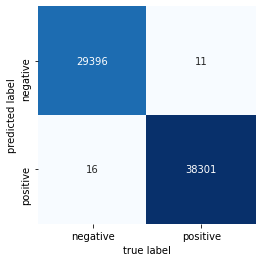

In [30]:

sns.heatmap(cm, square=True, annot=True, cmap="Blues", cbar=False,
xticklabels=["negative", "positive"], yticklabels=["negative", "positive"], fmt='g')
plt.xlabel("true label")
plt.ylabel("predicted label")

In [31]:
#https://mljar.com/blog/feature-importance-in-random-forest/
rf.feature_importances_

array([0.11035797, 0.16351123, 0.02787378, 0.15902995, 0.0868038 ,
       0.06306444, 0.04962743, 0.01175856, 0.00866003, 0.02929386,
       0.25677174, 0.03324722])

<BarContainer object of 12 artists>

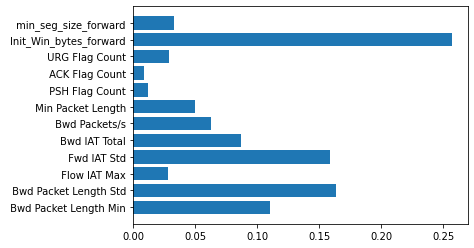

In [32]:
plt.barh(df1.columns.values[:-1], rf.feature_importances_)

<BarContainer object of 12 artists>

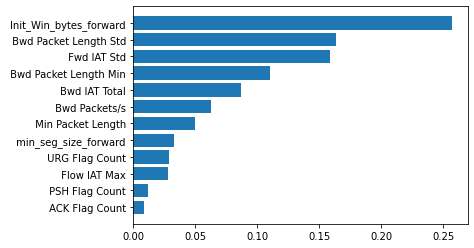

In [33]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df1.columns.values[:-1][sorted_idx], rf.feature_importances_[sorted_idx])

In [58]:
for i, df in enumerate(df_all):
    if i + 1 == 4:
        continue
    print("DF" + str(i + 1))
    randomForest(df)

DF1
38317
Accuracy score:  0.9995717913885772
Precision score:  0.9996867822092295
Recall score:  0.9995563326982801
F1 score:  0.9996215531978755
F2 score:  0.999582419876814
FP/A:  0.9995563326982801
TN  29395
FN  12
FP  17
TP  38300
AUCROC  0.9995741332957855
Confusion Matrix:  [[29395    12]
 [   17 38300]]
DF2
47679
Accuracy score:  0.9999069128820935
Precision score:  0.9999790237660731
Recall score:  0.9998531848402861
F1 score:  0.9999161003439886
F2 score:  0.999878350091657
FP/A:  0.9998531848402861
TN  38261
FN  1
FP  7
TP  47672
AUCROC  0.9999135246244187
Confusion Matrix:  [[38261     1]
 [    7 47672]]
DF3
608
Accuracy score:  0.9992845925667423
Precision score:  0.9780775716694773
Recall score:  0.9539473684210527
F1 score:  0.9658617818484596
F2 score:  0.9586776859504132
FP/A:  0.9539473684210527
TN  56689
FN  13
FP  28
TP  580
AUCROC  0.9768590498060962
Confusion Matrix:  [[56689    13]
 [   28   580]]
DF5
12
Accuracy score:  0.9999191508529585
Precision score:  1.0
R

In [54]:
randomForest(df_all[0])

38408
Accuracy score:  0.9996160888311382
Precision score:  0.999583485187692
Recall score:  0.9997396375755051
F1 score:  0.9996615552836428
F2 score:  0.9997084031950678
FP/A:  0.0002603624244948969
TN  29300
FN  16
FP  10
TP  38398
AUCROC  0.999596930262715
Confusion Matrix:  [[29300    16]
 [   10 38398]]


(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 array([1, 1, 1, ..., 1, 0, 1]))

In [44]:
df_combined = pd.concat([df1, df2, df3, df5, df6, df7, df8], ignore_index=True) #Ignore df4

In [48]:
df_combined[" Label"].value_counts()

BENIGN                        1743179
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name:  Label, dtype: int64

In [67]:
def randomForestCombined(df, labelPositive):
    labels = df[" Label"]
    train = df.drop(columns = [" Label"])
    
    replace = {}
    for label in df_combined[" Label"].unique():
        replace[label] = 1 if label == labelPositive else 0
    labels = labels.replace(replace)

    rf = RandomForestClassifier()

    xtrain, xtest, ytrain, ytest = train_test_split(train, labels, test_size=0.3, random_state=0) #stratify=labels)
    rf.fit(xtrain, ytrain)
    predictions = rf.predict(xtest)
    cm = confusion_matrix(ytest, predictions)
    print(labelPositive)
    print("Accuracy score: ", accuracy_score(ytest, predictions))
    print("F1 score: ", f1_score(ytest, predictions))
    print("F2 score: ", fbeta_score(ytest, predictions, 2))
    print("AUCROC ", roc_auc_score(ytest, predictions))
    print("Precision score: ", precision_score(ytest, predictions))
    print("Recall score: ", recall_score(ytest, predictions))
    print("Sensitivity: ", 1-(cm[1][0] / ytest.value_counts()[1]))
    print("Confusion Matrix: ", cm)
    return rf, predictions

In [71]:
randomForestCombined(df_combined, "DDoS")

DDoS
Accuracy score:  0.9999188697395719
F1 score:  0.9992707953539247
F2 score:  0.9992551811784806
AUCROC  0.999601675681755
Precision score:  0.9992968200640675
Recall score:  0.9992447719992709
Sensitivity:  0.9992447719992709
Confusion Matrix:  [[651822     27]
 [    29  38370]]


(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 array([0, 0, 0, ..., 0, 0, 0]))

In [70]:
randomForestCombined(df_combined, "PortScan")

PortScan
Accuracy score:  0.9995233597199847
F1 score:  0.9965540717465305
F2 score:  0.9983170070425491
AUCROC  0.9995105849540717
Precision score:  0.9936296420067672
Recall score:  0.999495766539908
Sensitivity:  0.999495766539908
Confusion Matrix:  [[642346    305]
 [    24  47573]]


(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 array([0, 0, 0, ..., 0, 0, 0]))

In [81]:
for label in df_combined[" Label"].unique()[3:5]:
    randomForestCombined(df_combined, label)

Bot
Accuracy score:  0.9995914511885583
F1 score:  0.7539267015706805
F2 score:  0.7339449541284403
AUCROC  0.8605176259232361
Precision score:  0.7897623400365631
Recall score:  0.7212020033388982
Sensitivity:  0.7212020033388982
Confusion Matrix:  [[689534    115]
 [   167    432]]
Infiltration
Accuracy score:  0.9999927562267474
F1 score:  0.7368421052631579
F2 score:  0.6363636363636365
AUCROC  0.7916666666666667
Precision score:  1.0
Recall score:  0.5833333333333334
Sensitivity:  0.5833333333333333
Confusion Matrix:  [[690236      0]
 [     5      7]]


In [83]:
for label in df_combined[" Label"].unique()[5:8]:
    randomForestCombined(df_combined, label)

Web Attack � Brute Force
Accuracy score:  0.9996392600920249
F1 score:  0.7381703470031545
F2 score:  0.7433290978398984
AUCROC  0.873310022102085
Precision score:  0.7297297297297297
Recall score:  0.7468085106382979
Sensitivity:  0.7468085106382979
Confusion Matrix:  [[689648    130]
 [   119    351]]
Web Attack � XSS
Accuracy score:  0.9996725814489864
F1 score:  0.3542857142857143
F2 score:  0.3252885624344176
AUCROC  0.6541658165371055
Precision score:  0.4161073825503356
Recall score:  0.30845771144278605
Sensitivity:  0.3084577114427861
Confusion Matrix:  [[689960     87]
 [   139     62]]
Web Attack � Sql Injection
Accuracy score:  0.9999927562267474
F1 score:  0.0
F2 score:  0.0
AUCROC  0.5


/home/victwj/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision score:  0.0
Recall score:  0.0
Sensitivity:  0.0
Confusion Matrix:  [[690243      0]
 [     5      0]]


In [84]:
for label in df_combined[" Label"].unique()[8:]:
    randomForestCombined(df_combined, label)

FTP-Patator
Accuracy score:  0.9998913434012123
F1 score:  0.9845520082389289
F2 score:  0.9786258291704201
AUCROC  0.9873478089035032
Precision score:  0.9945900957136912
Recall score:  0.9747145187601958
Sensitivity:  0.9747145187601958
Confusion Matrix:  [[687783     13]
 [    62   2390]]
SSH-Patator
Accuracy score:  0.9999739224162909
F1 score:  0.9947735191637631
F2 score:  0.9923531456378172
AUCROC  0.9953715956118826
Precision score:  0.9988338192419826
Recall score:  0.9907460960092539
Sensitivity:  0.9907460960092539
Confusion Matrix:  [[688517      2]
 [    16   1713]]
DoS slowloris
Accuracy score:  0.9999116259663193
F1 score:  0.9826950354609929
F2 score:  0.9848743318548846
AUCROC  0.9931394166964645
Precision score:  0.9790842283776144
Recall score:  0.9863325740318907
Sensitivity:  0.9863325740318907
Confusion Matrix:  [[688455     37]
 [    24   1732]]
DoS Slowhttptest
Accuracy score:  0.9998160081593862
F1 score:  0.9624593556015371
F2 score:  0.9726371131556936
AUCROC